<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/main_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [オゾンレベルの分類](https://signate.jp/competitions/123)

Refered to ["Tensorflow - Classification on imbalanced data"](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?authuser=1)

## Google Colabの設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#TEMP_DIR = "./temp"
INPUT_DIR:str = "/content/drive/MyDrive/Ozone_Level_Detection/01_input"
#TRAIN_DIR:str = INPUT_DIR + "/train_data"
#TEST_DIR:str = INPUT_DIR + "/test_data"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Ozone_Level_Detection/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Ozone_Level_Detection//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Ozone_Level_Detection/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

## メインコード

In [3]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
df = pd.read_csv(INPUT_DIR+"/train.tsv", index_col='Date', parse_dates=True, sep='\t')
df = df.drop(['id'], axis=1)

In [6]:
df

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,OZONE
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.90,10330.0,-55.0,0.00,0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805.0,14.05,29.00,10275.0,-55.0,0.00,0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.60,6.94,9.80,5790.0,17.90,41.30,10235.0,-40.0,0.00,0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,2.08,0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-06-29,0.8,0.9,0.3,0.3,0.7,0.8,1.3,1.9,3.0,3.0,...,0.45,8.65,-1.27,5870.0,27.80,44.80,10190.0,-25.0,0.05,0
2001-06-30,1.0,0.7,0.8,0.6,0.9,1.2,1.3,1.7,2.8,2.9,...,0.65,5.38,2.00,5850.0,35.60,49.60,10175.0,-15.0,0.18,0
2001-07-01,0.7,1.0,1.4,0.9,1.0,1.2,1.4,1.4,1.1,2.0,...,0.22,2.29,4.09,5855.0,32.10,48.20,10155.0,-20.0,0.23,0


In [7]:
# showing column wise %ge of NaN values they contains
null_col = []
for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)
  if df[i].isna().mean()*100 > 0:
    null_col.append(i)

WSR0 	-	 2.131018153117601
WSR1 	-	 2.131018153117601
WSR2 	-	 2.209944751381215
WSR3 	-	 2.131018153117601
WSR4 	-	 2.131018153117601
WSR5 	-	 2.131018153117601
WSR6 	-	 2.0520915548539858
WSR7 	-	 1.8153117600631412
WSR8 	-	 1.8942383583267564
WSR9 	-	 2.0520915548539858
WSR10 	-	 2.0520915548539858
WSR11 	-	 1.973164956590371
WSR12 	-	 1.8942383583267564
WSR13 	-	 2.0520915548539858
WSR14 	-	 2.0520915548539858
WSR15 	-	 1.8942383583267564
WSR16 	-	 1.8942383583267564
WSR17 	-	 1.8153117600631412
WSR18 	-	 1.8942383583267564
WSR19 	-	 2.131018153117601
WSR20 	-	 2.131018153117601
WSR21 	-	 2.131018153117601
WSR22 	-	 2.131018153117601
WSR23 	-	 2.131018153117601
WSR_PK 	-	 1.5785319652722969
WSR_AV 	-	 1.5785319652722969
T0 	-	 0.3946329913180742
T1 	-	 0.3946329913180742
T2 	-	 0.4735595895816891
T3 	-	 0.3946329913180742
T4 	-	 0.3946329913180742
T5 	-	 0.3946329913180742
T6 	-	 0.4735595895816891
T7 	-	 0.31570639305445936
T8 	-	 0.31570639305445936
T9 	-	 0.4735595895816891
T10 

In [8]:
# Since dataset contains values in str format, changing it into float values

for i in df.columns[1:-1]:
  df[i] = df[i].astype(str).astype(float)

for i in null_col:
  df[i] = df[i].fillna(df[i].mean())

# lets check for null values again
for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)

WSR0 	-	 0.0
WSR1 	-	 0.0
WSR2 	-	 0.0
WSR3 	-	 0.0
WSR4 	-	 0.0
WSR5 	-	 0.0
WSR6 	-	 0.0
WSR7 	-	 0.0
WSR8 	-	 0.0
WSR9 	-	 0.0
WSR10 	-	 0.0
WSR11 	-	 0.0
WSR12 	-	 0.0
WSR13 	-	 0.0
WSR14 	-	 0.0
WSR15 	-	 0.0
WSR16 	-	 0.0
WSR17 	-	 0.0
WSR18 	-	 0.0
WSR19 	-	 0.0
WSR20 	-	 0.0
WSR21 	-	 0.0
WSR22 	-	 0.0
WSR23 	-	 0.0
WSR_PK 	-	 0.0
WSR_AV 	-	 0.0
T0 	-	 0.0
T1 	-	 0.0
T2 	-	 0.0
T3 	-	 0.0
T4 	-	 0.0
T5 	-	 0.0
T6 	-	 0.0
T7 	-	 0.0
T8 	-	 0.0
T9 	-	 0.0
T10 	-	 0.0
T11 	-	 0.0
T12 	-	 0.0
T13 	-	 0.0
T14 	-	 0.0
T15 	-	 0.0
T16 	-	 0.0
T17 	-	 0.0
T18 	-	 0.0
T19 	-	 0.0
T20 	-	 0.0
T21 	-	 0.0
T22 	-	 0.0
T23 	-	 0.0
T_PK 	-	 0.0
T_AV 	-	 0.0
T85 	-	 0.0
RH85 	-	 0.0
U85 	-	 0.0
V85 	-	 0.0
HT85 	-	 0.0
T70 	-	 0.0
RH70 	-	 0.0
U70 	-	 0.0
V70 	-	 0.0
HT70 	-	 0.0
T50 	-	 0.0
RH50 	-	 0.0
U50 	-	 0.0
V50 	-	 0.0
HT50 	-	 0.0
KI 	-	 0.0
TT 	-	 0.0
SLP 	-	 0.0
SLP_ 	-	 0.0
Precp 	-	 0.0
OZONE 	-	 0.0


In [9]:
neg, pos = np.bincount(df['OZONE'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1267
    Positive: 111 (8.76% of total)



### One-Hold法

In [10]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('OZONE'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('OZONE'))

train_features = np.array(train_df)
val_features = np.array(val_df)

In [11]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')

Average class probability in training set:   0.0958
Average class probability in validation set: 0.0551


In [12]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (1013,)
Validation labels shape: (254,)
Training features shape: (1013, 72)
Validation features shape: (254, 72)


#### Look at the data distribution

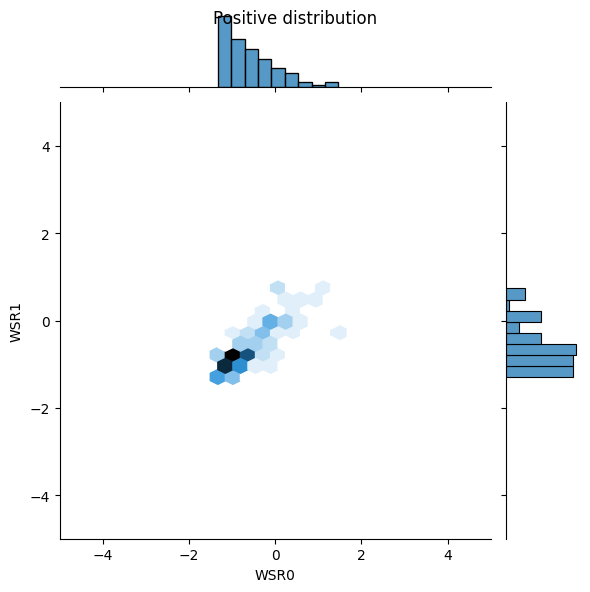

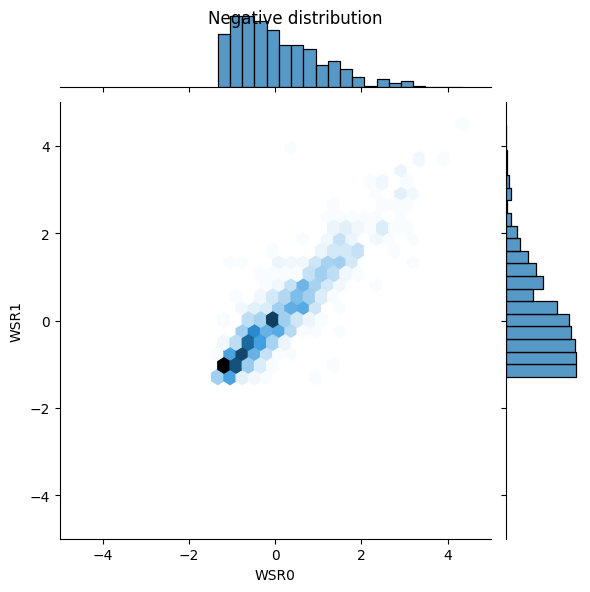

In [13]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['WSR0'], y=pos_df['WSR1'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['WSR0'], y=neg_df['WSR1'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")


#### Define the model and metrics

In [14]:
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
val_features = val_features.reshape((val_features.shape[0], val_features.shape[1], 1))

In [15]:
train_features.shape

(1013, 72, 1)

In [16]:
val_features.shape

(254, 72, 1)

In [17]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  input_layer = keras.layers.Input(train_features.shape[1:])
  conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.Activation(activation='relu')(conv1)
  conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.Activation('relu')(conv2)
  conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.Activation('relu')(conv3)
  gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
  output_layer = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(gap_layer)
  model = keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#### Baseline model（CNN）

In [18]:
# Build the model

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [19]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 72, 128)           1152      
                                                                 
 batch_normalization (Batch  (None, 72, 128)           512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 72, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 256)           164096    
                                                                 
 batch_normalization_1 (Bat  (None, 72, 256)           1024      
 chNormalization)                                            

In [20]:
model.predict(train_features[:10])

1/1 [==============================] - 1s 559ms/step


array([[0.80965644],
       [0.8076971 ],
       [0.8118091 ],
       [0.81134874],
       [0.80872947],
       [0.8123928 ],
       [0.8062371 ],
       [0.8160685 ],
       [0.8144576 ],
       [0.81744945]], dtype=float32)

#### Set the correct initial bias.

In [21]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5335


In [22]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.34319085])

In [23]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 1s 840ms/step


array([[0.09383413],
       [0.09228164],
       [0.09541012],
       [0.09784361],
       [0.09448568],
       [0.10000465],
       [0.09185528],
       [0.10250098],
       [0.10272285],
       [0.10224875]], dtype=float32)

In [24]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3166


#### Checkpoint the initial weights

In [25]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

#### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

#### Check training history

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
plot_metrics(baseline_history)

#### Evaluate metrics

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, val_predictions_baseline)

#### Changing the threshold

In [ ]:
plot_cm(val_labels, val_predictions_baseline, threshold=0.1)
plot_cm(val_labels, val_predictions_baseline, threshold=0.01)

#### Plot the ROC

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

#### Plot the PRC

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

#### Class weights

##### Calculate class weights

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

##### Train a model with class weights

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

##### Check training history

In [ ]:
plot_metrics(weighted_history)

##### Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(val_features, val_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, val_predictions_weighted)

##### Plot the ROC

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("val Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("val Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

##### Plot the PRC

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("val Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("val Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


#### Oversampling

##### Oversample the minority class

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

##### Using NumPy

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

##### Using tf.data

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

##### Train on the oversampled data

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

##### Check training history

In [ ]:
plot_metrics(resampled_history)

##### Re-train

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

##### Re-check training history

In [ ]:
plot_metrics(resampled_history)

##### Evaluate metrics

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_resampled = resampled_model.predict(val_features, batch_size=BATCH_SIZE)

In [ ]:
resampled_results = resampled_model.evaluate(val_features, val_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(val_labels, val_predictions_resampled)

##### Plot the ROC

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("val Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("val Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("val Resampled", val_labels, val_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

##### Plot the AUPRC

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("val Baseline", val_labels, val_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("val Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("val Resampled", val_labels, val_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
submit_df = pd.read_csv(INPUT_DIR+"/test.tsv", index_col=0, sep='\t')
submit_df = submit_df.drop(['Date'], axis=1)

In [ ]:
# showing column wise %ge of NaN values they contains
null_col = []

for i in submit_df.columns:
  print(i,"\t-\t", submit_df[i].isna().mean()*100)
  if submit_df[i].isna().mean()*100 > 0:
    null_col.append(i)

for i in submit_df.columns[1:-1]:
  submit_df[i] = submit_df[i].astype(str).astype(float)

In [ ]:
for i in null_col:
  submit_df[i] = submit_df[i].fillna(submit_df[i].mean())

# lets check for null values again
for i in submit_df.columns:
  print(i,"\t-\t", submit_df[i].isna().mean()*100)

In [ ]:
# Scale the data to be between -1 and 1

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pred_X = pd.DataFrame(scaler.fit_transform(submit_df), columns=submit_df.columns)
pred_X.head()

In [ ]:
pred = resampled_model.predict(pred_X)
pred = np.where(pred < 0.5, 0, 1)

In [ ]:
pred

In [ ]:
ans = pd.read_csv(INPUT_DIR+"/sample_submit.csv",  header=None)
ans[1] = pred
ans.to_csv(path_or_buf = SUBMISSION_DIR+"/submit.csv", index=False, header=None)